# Minnesota Landslide Susceptibility 

Whitney DeLong (MGIS), Elise Rosengren (MGIS), and Lauren Strug (MGIS)

INTRODUCTION:

Landslides cause damage to natural and urban environments, causing significant property loss and posing a potential risk to people. According to Brabb (1993), 90% of landslide losses can be avoided through the prediction of slope failure before the event. Specifically across Minnesota, landslides are a threat to environmental sustainability as sediment overload effects water quality and ecosystems. Historically, landslides in Minnesota have also been detrimental to public and private infrastructure such as state parks, homes, and roads. 

As landslide frequency and severity is potentially increasing throughout Minnesota, monitoring potential landslide locations becomes essential. Monitoring can help mitigate problems associated with landslides which can cause injury and are costly to the state.  Automating some of the data processing would allow for more predictive analysis of future landslide locations and more targeted mitigation projects as they relate specifically to Minnesota.

Currently the Legislative-Citizen Commission on Minnesota Resources (LCCMR) is working to identify active landslides throughout the state with the ultimate goal of creating landslide susceptibility maps.  Quantitative analysis of lidar data and landslide inventory will be used in the creation of these maps.  Our work is in conjunction with the LCCMR with a goal of creating  python programs for analysis of landslide susceptibility using lidar-derived DEM data.

We will provide a quantitative measure of landslide susceptibility by creating a set of programs to perform four analyses of slope stability.  The most important measures to assess landslide susceptibility and slope stability are shaded relief (45* and 315* azimuth to address shadowing), aspect, and slope.  These measures are from the LCCMR Landslide Hazards and Impacts on Minnesota’s Natural Environment Project. 

METHODS:  

Simple summary of methods:
1) A 1-meter DEM (geotiff) created by Dr. Andy Wickert (Earth Sciences) from 2011 Minnesota lidar data was acquired.
2) Using GRASS GIS, the DEM was formatted into 2km tiles covering the state of Minnesota to create a reasonable size for the scope of this project. 
3) Python, Jupyter Notebook, and GitHub were used to create code that provides a quantitative measure of landslide susceptibility over one tile.  The components examined using the python code included: hillshade with 45* azimuth, hillshade with 315* azimuth, aspect, and slope. 

CODE: 

Tiling:

In [1]:
# The following two code cells were done in GRASS GIS (They will not run in this notebook). 
# MN DEM was broken down into 2 km x 2km tiles with 50 m overlap for subsequent processing. 

g.region -gf # Manages boundary definitions for geographic region
projection=1 # Match the projection of the input
zone=15 # Define UTM zone
# The following parameters define the extent, resolution, and number of rows, columns, and cells.
n=5472435 s=4812867.23583161 w=188544 e=763445 nsres=0.99999964 ewres=1 rows=659568 cols=574901 cells=379186302768 # ???
r.tile input=MinnesotaLiDAR output=MN_lidar_tile_ width=2000 height=2000 overlap=50 # Define input, output, width, height, and overlap of tiles. 

In [ ]:
# The following code was used to export tiles created in previous step to a folder for subsequent processing. 

import grass.script as grass

# Create list of all rasters and split at delimiter. 
rastList=grass.read_command("g.list", mapset="PERMANENT", type="rast") 
RastListClean=rastlist.split() 

# Export from GRASS workspace 
for raster in RastListClean: 
    grass.run_command('g.region', raster=raster)
    grass.run_command('r.out.gdal', overwrite=True, input=raster, output=raster + '_dem.tif', format = 'GTiff', type='Float64', nodata='-9999')

Exploring and mapping geotiff files using rasterio:

In [26]:
import rasterio

folder = "C:\\Users\\Lauren\\Downloads\\Lidar tiles" #Locates folder with multiple geoTIFFS
file = "C:\\Users\\Lauren\\Downloads\\Lidar tiles\\MN_lidar_tile_-120-114_dem.tif" #Locates an individual tif file
lidar_tile_120 = rasterio.open(file) #Opens file

import os.path #Checks the connection to the file
os.path.isfile(file)

True

In [29]:
lidar_tile_120.profile #Gets metadata

{'affine': Affine(1.0, 0.0, 416494.0,
       0.0, -0.9999996424475242, 5232485.08579524),
 'count': 1,
 'crs': CRS({'init': 'epsg:26915'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 2100,
 'interleave': 'band',
 'nodata': -9999.0,
 'tiled': False,
 'transform': (416494.0, 1.0, 0.0, 5232485.08579524, 0.0, -0.9999996424475242),
 'width': 2100}

In [30]:
lidar_tile_120.indexes #Checks number of bands

(1,)

In [31]:
lidar_tile_120.read(1) #Reads first band

array([[ 400.76002178,  400.76999326,  400.75001309, ...,  393.60998379,
         393.55000605,  393.48001963],
       [ 400.67998945,  400.70000684,  400.73003291, ...,  393.54003457,
         393.5100085 ,  393.4999998 ],
       [ 400.71001553,  400.73003291,  400.78000195, ...,  393.48999111,
         393.4999998 ,  393.5100085 ],
       ..., 
       [ 395.97002578,  395.99000596,  395.91001084, ...,  397.80001641,
         397.89002021,  397.94002646],
       [ 396.01999482,  395.97002578,  395.90000215, ...,  397.87000283,
         397.91000039,  397.94002646],
       [ 395.9500084 ,  395.98003447,  396.00001465, ...,  397.88001152,
         397.89002021,  397.92000908]])

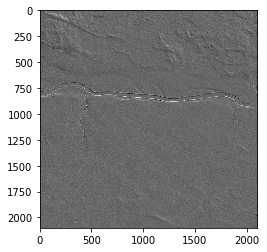

In [27]:
import matplotlib.pyplot as plt

with rasterio.open(file) as src: #Opens individual tiff file and reads the first band as an array
    band1 = src.read(1)
    
hshade_array = hillshade(band1, 45, 45) #Uses hillshade function to create new array
plt.imshow(hshade_array, cmap = 'Greys') #Plots hillshade array
plt.show()

METHODS FOR HILLSHADE 315, HILLSHADE 45, SLOPE, and ASPECT FUNCTIONS:

   The following cell includes the functions for hillshade, slope, and aspect. There are many online resources that show the principles behind the hillshade function. We felt it would be very difficult to come up with a mathmatically correct hillshade function without referencing existing online functions. We referenced hillshade functions from Esri, NeonDataSkills.org, and geologyandpython.com. Ulitmately, we thought the following would be very practical as it uses numpy and shows how to take the DEM information in as an array.
    Finding hillshade shows you the hypothetical illumination surface for the values in each cell of a raster. In this case we pass the values of the cells in the raster as an array. We need to specify the azimuth, which is the direction of the illumnation source, in degrees. Additionally, we specify the angle altitude which is the altitude of the illumination source. 
    We defined the functions for slope and aspect based on the function for hillshade because slope and aspect are a part of that calculation. The functions for slope and aspect also take the DEM information in as an array. 

In [7]:
import numpy as np

def hillshade(array, azimuth, angle_altitude): #Hillshade function based on ESRI hillshade
    x, y = np.gradient(array) # http://geologyandpython.com/dem-processing.html
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.

    shaded = np.sin(altituderad) * np.sin(slope) \
    + np.cos(altituderad) * np.cos(slope) \
    * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

def slope(array): #Slope function
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    return slope

def aspect(array): #Aspect Function
    x, y = np.gradient(array)
    aspect = np.arctan2(-x, y)
    return aspect

METHODS FOR GEOTIFF PROCESSING AND FILE CREATION USING GDAL:

   First, the path is defined for the folder where the tif files are stored. The function, create_tif, uses GDAL functions to write a new array. It takes four parameters: the outfilename is the path where the file will be stored which includes the name of the new file; the parameter arr_out refers to which function (above) will be performed on the file being passed through; and finally, rows and cols refers to the length and width of the cells of the raster.
    The purpose of the following code is to loop through the tif files within a folder, perform all functions on each tif (hillshade with a 45 degree azimuth, hillshade with a 315 degree azimuth, slope, and aspect) and have those new tifs be written out to separate folders labelled for each function. 
    The first step of the loop uses os and glob to iterate over each item in the path that ends in .tif. The tif is opened using gdal. Each tif has one band, so the band is read as an array which makes it appropriate to pass through our functions defined above. For each tif we also find the shape using numpy to get the number of cells in the rows and columns for the create_tif function. Then, within the loop, we store a list with each of the functions calling the band as an array and with the specified parameters we want, a list of the names of the folders located on the computer where the outputs will be stored, and a list of the file endings that we want to use on the end of the new tifs created. 
    The final step of the proccess is a loop within the initial loop. The loop iterates four times because each of our lists has four items within it. The order of the items in the list are important because the number of iteration through the loop corresponds to which item in the loop is used for i. For each tif that goes through the initial loop, this second loop creates a new folder path by adding the initial path, the folder the new tif will be stored in, the name of the initial tif excluding ".tif" from the name, and the new ending we would like to add to the new tif. Then, within this loop we call the create_tif function calling the path we create in the loop as the output file. The list of functions is called in the function where the iteration through the loop corresponds to the function we call, that way four iterations through the loop gets us each function, and the row and column size of the tif. And finally, it is important to close the files when we are done. 

In [8]:
import os 
import glob
import gdal 

path = 'C:\\Users\\Lauren\\Downloads\\Lidar tiles' #Locates folder with multiple tif files stored in it

#create function for driver = gdal to outdada.flushCashe() where outfilename and arr_out are the parameters
def create_tif(outfilename, arr_out, rows, cols):
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(outfilename, rows, cols, 1, gdal.GDT_UInt32)
    outband = outdata.GetRasterBand(1)
    outdata.SetProjection(ds.GetProjection())#sets same projection as input
    outband.WriteArray(arr_out)
    outdata.FlushCache() #saves to disk
    
    
for filename in glob.glob(os.path.join(path, '*.tif')): #Loop through folder with files ending in .tif
    ds = gdal.Open(filename) #Open file using gdal
    band = ds.GetRasterBand(1)
    band1 = band.ReadAsArray() #Reads band 1 as an array

    shapelist = band1.shape #Gets the size of the array with numpy
    cols = shapelist[0] #Stores the width of the raster
    rows = shapelist[1] #stores the height of the raster
    
    input_functions = [hillshade(band1, 45, 45), hillshade(band1, 315, 45), slope(band1), aspect(band1)] #List of functions
    folder = ['hillshade45','hillshade315','slope','aspect'] #List of folders where the output of functions will be stored
    endings = ['_shd45.tif','_shd315.tif','_slp.tif','_apt.tif'] #List of endings for each folder type 
    
    for i in range(0,4): #Loops through four times
        folderpath = path + "\\" + folder[i] + "\\" + filename[38:-4] + endings[i] #output folder is equal to the lidar tiles folder 
        create_tif(folderpath, input_functions[i], rows, cols)                  #plus the folder we are iterating through, plus
                                                                                #the filename minus the last 4 characters, plus
                                                                                #the file ending. 
    outdata = None #important to close the files
    band = None
    ds = None 

RESULTS:

As a result of our code, we created a way of organizing the output looping through input geotiffs, performing our four functions, and writing four separate new geotiffs with appropriate file names and folder locations. A suggested next step would be to include programming to examine slope with short slopes removed, contour, and red relief.  This would provide an even more detailed analysis of landslide susceptibility in the future. Another change in the final code for the project would be to find a more sustainable way to get the filename of the geotiff within the second loop. Using the splitting method (filename[38:-4]) assumes that all of our file names are the same length. For this project, this is true, but going forward the program would have more flexability if there was an updated way of getting only the part of the file name that we care about. Below is a sample of our results for one of our input dem files. 

C:\Users\Lauren\Anaconda3\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


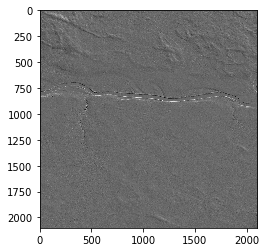

In [38]:
import matplotlib.pyplot as plt

path = 'C:\\Users\\Lauren\\Downloads\\Lidar tiles\\hillshade45\\MN_lidar_tile_-120-114_dem_shd45.tif' #Hillshade45 output location
with rasterio.open(path) as src: #Opens tif in folder with rasterio
    band1 = src.read(1)
    plt.imshow(band1, cmap = 'Greys') #Plots hillshade  45 array
    plt.show()

C:\Users\Lauren\Anaconda3\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


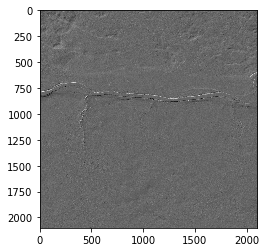

In [34]:
path = 'C:\\Users\\Lauren\\Downloads\\Lidar tiles\\hillshade315\\MN_lidar_tile_-120-114_dem_shd315.tif' #Hillshade 315 output location
with rasterio.open(path) as src: #Opens tif in folder with rasterio
    band1 = src.read(1)
    plt.imshow(band1, cmap = 'Greys') #Plots hillshade 315 array
    plt.show()

C:\Users\Lauren\Anaconda3\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


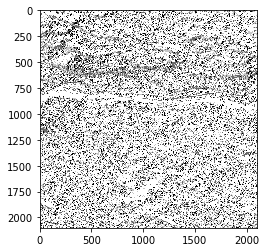

In [35]:
path = 'C:\\Users\\Lauren\\Downloads\\Lidar tiles\\aspect\\MN_lidar_tile_-120-114_dem_apt.tif' #Aspect output location
with rasterio.open(path) as src: #Opens tif in folder with rasterio
    band1 = src.read(1)
    plt.imshow(band1, cmap = 'Greys') #Plots aspect array
    plt.show()

C:\Users\Lauren\Anaconda3\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


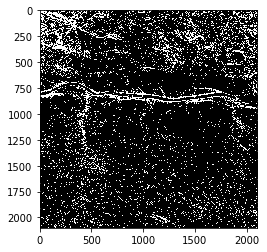

In [36]:
path = 'C:\\Users\\Lauren\\Downloads\\Lidar tiles\\slope\\MN_lidar_tile_-120-114_dem_slp.tif' #Slope output location
with rasterio.open(path) as src: #Opens tif in folder with rasterio
    band1 = src.read(1)
    plt.imshow(band1, cmap = 'Greys') #Plots slope array
    plt.show()

CONCLUSIONS:

With this project we were able to acquire a 1-meter DEM derived from lidar data, convert the data into 2km tiles for better processing, visualization, and data management, and create code that provides a measure of landslide susceptibility over a tile.  We were able to  provide a quantitative measure of landslide susceptibility by creating a set of programs to perform analyses of slope stability including azimuth 45*, azimuth 315*, aspect, and slope.  This code can be used as a predictive tool for Minnesota landslide susceptibility. 

REFERENCES:

Brabb, E. 1993. Proposal for worldwide landslide hazard maps. In: Novosad, S. & Wagner, P. (eds.)
Proceedings of the 7th International Conference and Workshop on Landslides. A.A. Balkema,
Czech and Slovak Republics, 15-27.

Environmental and Natural Resources Trust Fund M.L. 2017, LCCMR Work Plan
https://www.lccmr.leg.mn/projects/2017/work_plans_june/_2017_03i.pdf

Hillshade, GDAL, and geotiff tutorials:
http://www.gdal.org/gdal_tutorial.html
https://gis.stackexchange.com/questions/164853/reading-modifying-and-writing-a-geotiff-with-gdal-in-python
https://automating-gis-processes.github.io/2016/Lesson7-read-raster.html
https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
http://neondataskills.org/lidar/create-hillshade-py/  
http://edndoc.esri.com/arcobjects/9.2/net/shared/geoprocessing/spatial_analyst_tools/how_hillshade_works.htm 
http://geologyandpython.com/dem-processing.html